<a href="https://colab.research.google.com/github/Chetalam/AI-Coursework-2025/blob/main/Stars_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Stars.csv to Stars (1).csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Set display options for better output
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

<>:68: SyntaxWarning: invalid escape sequence '\o'
<>:68: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-1342983347.py:68: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('Luminosity ($L/L_\odot$) [Log Scale]')


Cleaned Column Names: ['Temperature', 'Luminosity', 'Radius', 'Absolute_magnitude', 'Star_type', 'Star_category', 'Star_color', 'Spectral_Class']

Missing Values (sum per column): 0
Number of Duplicate Rows: 0
Number of Rows After Dropping Duplicates: 240

DataFrame Head with Log Transformations:
| Temperature   | Luminosity   | Radius   | Absolute_magnitude   | Star_type   | Star_category   | Star_color   | Spectral_Class   | Log_Luminosity   | Log_Radius   |
|:--------------|:-------------|:---------|:---------------------|:------------|:----------------|:-------------|:-----------------|:-----------------|:-------------|
| 3068          | 0.0024       | 0.17     | 16.12                | 0           | Brown Dwarf     | Red          | M                | -2.61979         | -0.769551    |
| 3042          | 0.0005       | 0.1542   | 16.6                 | 0           | Brown Dwarf     | Red          | M                | -3.30103         | -0.811916    |

--- Pearson Correlation Matrix --

/tmp/ipython-input-1342983347.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Star_category', data=df, order=df['Star_category'].value_counts().index, palette='viridis')



Insights from EDA (Summary)
1. The dataset is perfectly balanced across the six 'Star_category' types (40 stars each).
2. The H-R Diagram clearly separates star types: Dwarfs (low Log_Luminosity), Main Sequence (diagonal band), and Giants/Supergiants (high Log_Luminosity).
3. Log-transformed features, especially **Log_Luminosity (r=0.90)** and **Absolute_magnitude (r=-0.96)**, show the strongest linear relationship with the target **Star_type**, making them excellent candidates for classification features in Q3/Q4.
4. Absolute Magnitude (Mv) serves as an effective proxy, clustering the brightest (most negative Mv) Supergiants/Hypergiants in the high Luminosity region.


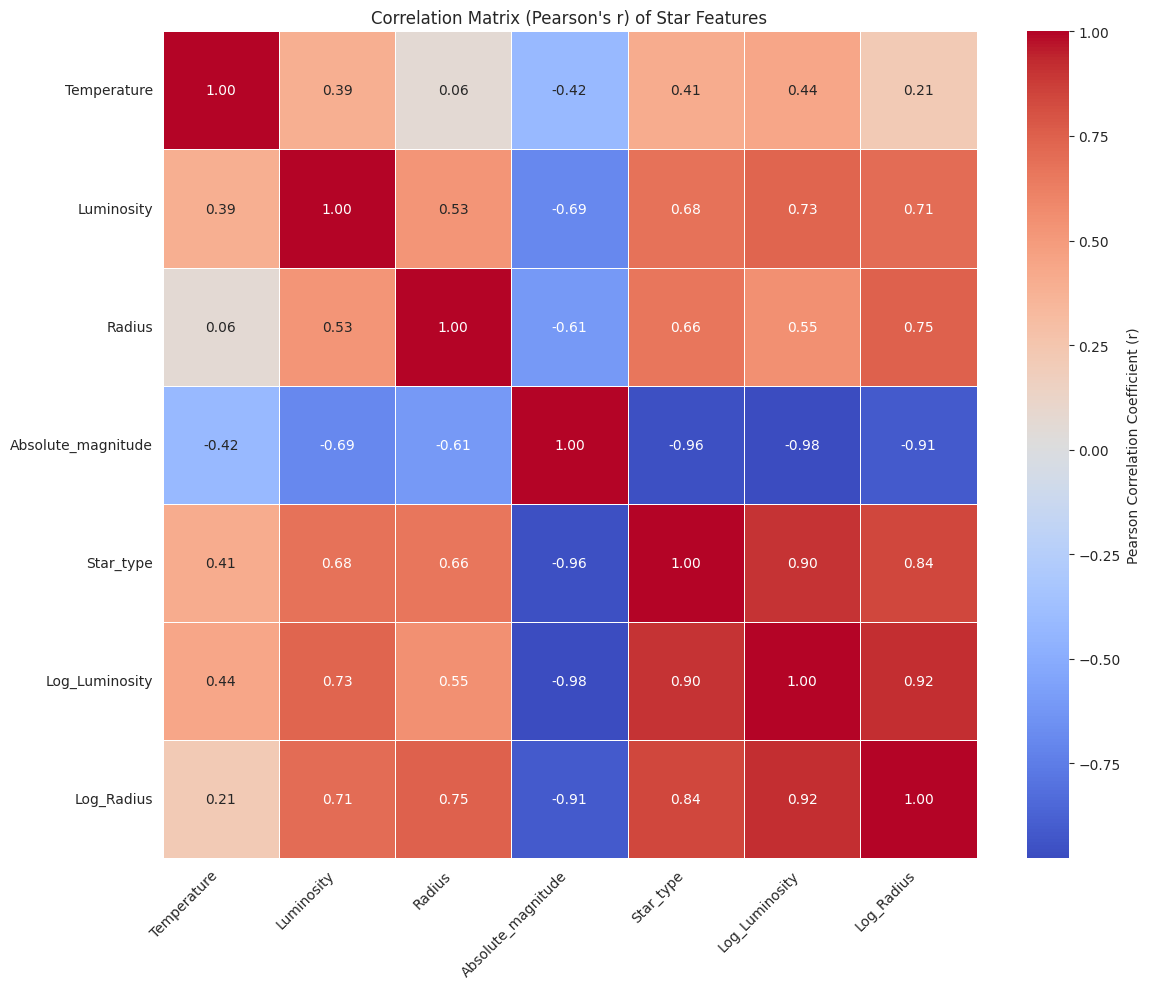

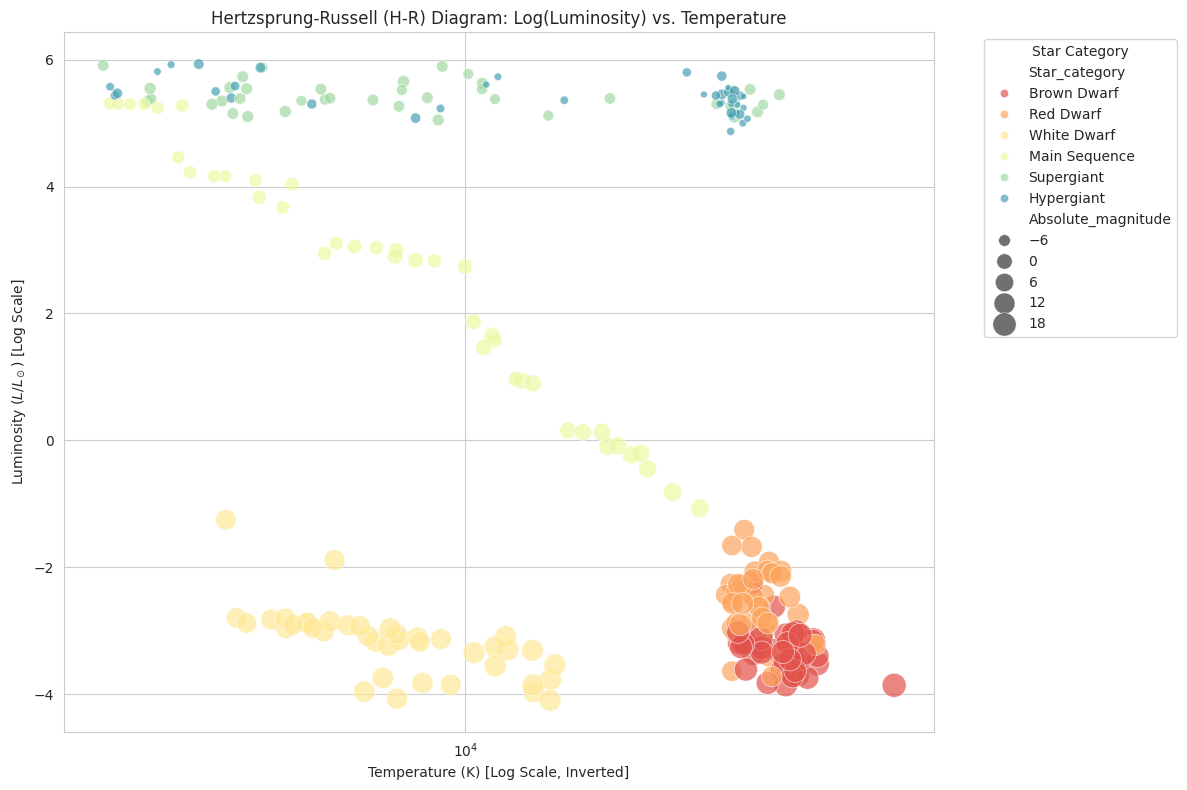

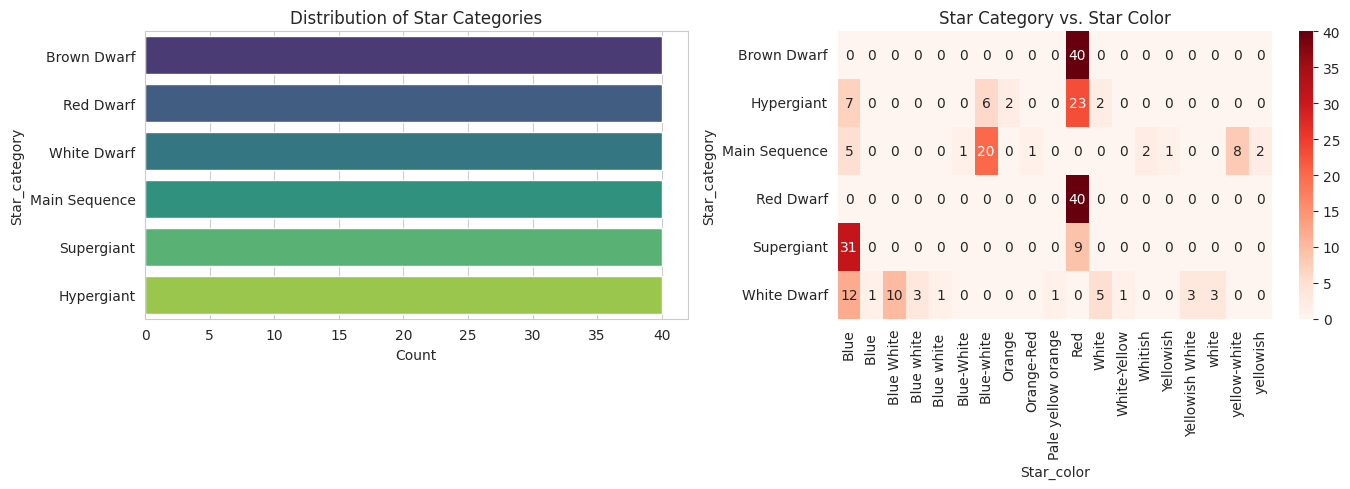

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Data Loading and Initial Cleaning ---
file_path = "Stars.csv"
df = pd.read_csv(file_path)

# Clean Column Names
def clean_col_name(col):
    """Removes units in parentheses and replaces spaces with underscores."""
    return col.split('(')[0].strip().replace(' ', '_')

df.columns = [clean_col_name(col) for col in df.columns]
print("Cleaned Column Names:", df.columns.tolist())

# Check for missing values and duplicates
print(f"\nMissing Values (sum per column): {df.isnull().sum().sum()}")
print(f"Number of Duplicate Rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Number of Rows After Dropping Duplicates: {len(df)}")

# --- Feature Engineering (Log Transformations) ---
# Log transformation for high-magnitude features is crucial for better model performance.
df['Log_Luminosity'] = np.log10(df['Luminosity'])
df['Log_Radius'] = np.log10(df['Radius'])
print("\nDataFrame Head with Log Transformations:")
print(df.head(2).to_markdown(index=False, numalign="left", stralign="left"))


# --- Insight 1: Pearson Correlation Matrix & Heatmap (Feature Selection) ---
numerical_df = df.select_dtypes(include=np.number)
correlation_matrix = numerical_df.corr(method='pearson')

print("\n--- Pearson Correlation Matrix ---")
print(correlation_matrix.to_markdown(numalign="left", stralign="left"))

print("\n--- Correlation with Target Variable (Star_type) ---")
print(correlation_matrix['Star_type'].sort_values(ascending=False).to_markdown(numalign="left", stralign="left"))

# Visualize the Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5,
            cbar_kws={'label': 'Pearson Correlation Coefficient (r)'})
plt.title('Correlation Matrix (Pearson\'s r) of Star Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')


# --- Insight 2: Hertzsprung-Russell (H-R) Diagram ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Temperature', y='Log_Luminosity',
    hue='Star_category', size='Absolute_magnitude',
    sizes=(20, 300), alpha=0.7, palette='Spectral', data=df
)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.title('Hertzsprung-Russell (H-R) Diagram: Log(Luminosity) vs. Temperature')
plt.xlabel('Temperature (K) [Log Scale, Inverted]')
plt.ylabel('Luminosity ($L/L_\odot$) [Log Scale]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Star Category')
plt.tight_layout()
plt.savefig('hr_diagram.png')
# # --- Insight 3 & 4: Star Type Distribution and Color relationship ---
plt.figure(figsize=(14, 5))

# Subplot 1: Distribution of Star Categories
plt.subplot(1, 2, 1)
sns.countplot(y='Star_category', data=df, order=df['Star_category'].value_counts().index, palette='viridis')
plt.title('Distribution of Star Categories')
plt.xlabel('Count')

# Subplot 2: Star Color vs. Star Category Cross-Tabulation
plt.subplot(1, 2, 2)
star_color_type = df.groupby(['Star_category', 'Star_color']).size().unstack(fill_value=0)
sns.heatmap(star_color_type, annot=True, fmt='d', cmap='Reds')
plt.title('Star Category vs. Star Color')
plt.tight_layout()
plt.savefig('star_distribution_and_color_heatmap.png')

print("\nInsights from EDA (Summary)")
print("1. The dataset is perfectly balanced across the six 'Star_category' types (40 stars each).")
print("2. The H-R Diagram clearly separates star types: Dwarfs (low Log_Luminosity), Main Sequence (diagonal band), and Giants/Supergiants (high Log_Luminosity).")
print("3. Log-transformed features, especially **Log_Luminosity (r=0.90)** and **Absolute_magnitude (r=-0.96)**, show the strongest linear relationship with the target **Star_type**, making them excellent candidates for classification features in Q3/Q4.")
print("4. Absolute Magnitude (Mv) serves as an effective proxy, clustering the brightest (most negative Mv) Supergiants/Hypergiants in the high Luminosity region.")

Optimal K value based on 5-Fold Cross-Validation: 5
Maximum Cross-Validated Accuracy: 0.9467

--- Final k-NN Model Evaluation ---
Test Accuracy with Optimal k=5: 0.8889

Classification Report:
               precision    recall  f1-score   support

  Brown Dwarf       1.00      1.00      1.00        12
   Hypergiant       1.00      0.83      0.91        12
Main Sequence       1.00      1.00      1.00        12
    Red Dwarf       0.80      0.67      0.73        12
   Supergiant       0.86      1.00      0.92        12
  White Dwarf       0.71      0.83      0.77        12

     accuracy                           0.89        72
    macro avg       0.90      0.89      0.89        72
 weighted avg       0.90      0.89      0.89        72


Confusion Matrix:
[[12  0  0  0  0  0]
 [ 0 10  0  0  2  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0  8  0  4]
 [ 0  0  0  0 12  0]
 [ 0  0  0  2  0 10]]


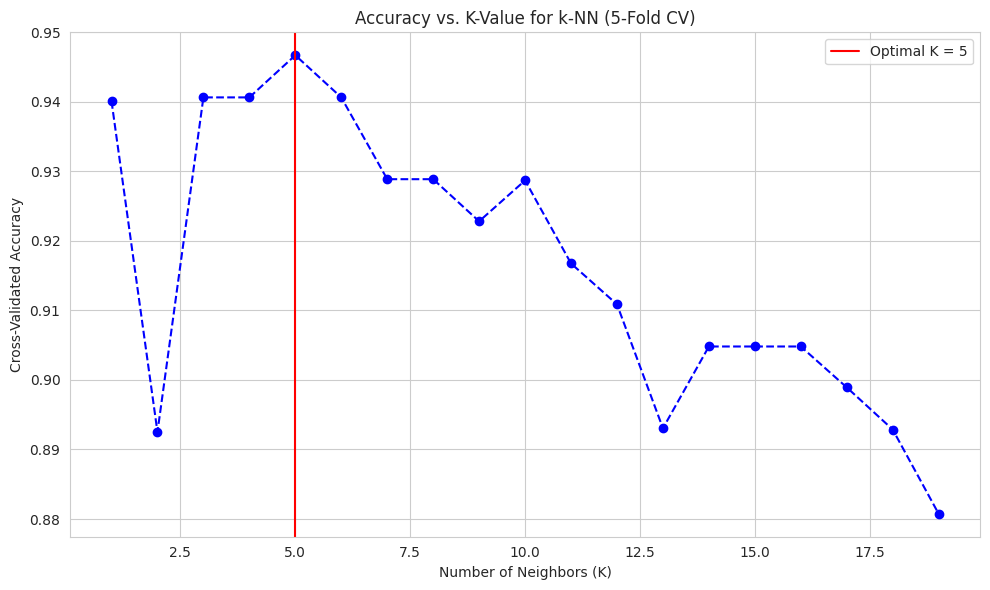

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# --- Feature and Target Definition ---
# Using the two most correlated features identified in EDA:
# 'Log_Luminosity' (r=0.90) and 'Absolute_magnitude' (r=-0.96).
features = ['Log_Luminosity', 'Absolute_magnitude']
X = df[features]
y = df['Star_category']

# Split Data (using stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standard Scaling (Crucial for k-NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# --- Determine Optimal k using Cross-Validation (Verification) ---
neighbors = list(range(1, 20))
cv_scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Use cross_val_score on the training data with 5-fold CV
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Identify the optimal k
optimal_k = neighbors[np.argmax(cv_scores)]
max_cv_score = max(cv_scores)

print(f"Optimal K value based on 5-Fold Cross-Validation: {optimal_k}")
print(f"Maximum Cross-Validated Accuracy: {max_cv_score:.4f}")

# Plot the accuracy vs k to visualize verification
plt.figure(figsize=(10, 6))
plt.plot(neighbors, cv_scores, marker='o', linestyle='--', color='b')
plt.title('Accuracy vs. K-Value for k-NN (5-Fold CV)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validated Accuracy')
plt.axvline(x=optimal_k, color='r', linestyle='-', label=f'Optimal K = {optimal_k}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('knn_optimal_k.png')


# --- Train Final k-NN Model and Evaluate ---
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train_scaled, y_train)
knn_predictions = knn_model.predict(X_test_scaled)

print("\n--- Final k-NN Model Evaluation ---")
test_accuracy = accuracy_score(y_test, knn_predictions)
print(f"Test Accuracy with Optimal k={optimal_k}: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, knn_predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, knn_predictions))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Note: X_train_scaled, y_train, X_test_scaled, y_test are used from the Question 3 setup.

# --- 4: Default Eager Learning Classifier (Decision Tree) ---

# Initialize Default Decision Tree (Eager Learner)
dt_default = DecisionTreeClassifier(random_state=42)

print("--- The Default Eager Learning Classifier (Decision Tree) ---")
print(dt_default)
print("-" * 55)

# Train the Model
dt_default.fit(X_train_scaled, y_train)

# Make Predictions
dt_default_predictions = dt_default.predict(X_test_scaled)

# --- Default Decision Tree Classifier Performance (Full Evaluation) ---
print("\n--- Default Decision Tree Classifier Performance ---")
test_accuracy = accuracy_score(y_test, dt_default_predictions)
print(f"Test Accuracy (on test set): {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, dt_default_predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, dt_default_predictions))

--- The Default Eager Learning Classifier (Decision Tree) ---
DecisionTreeClassifier(random_state=42)
-------------------------------------------------------

--- Default Decision Tree Classifier Performance ---
Test Accuracy (on test set): 0.9028

Classification Report:
               precision    recall  f1-score   support

  Brown Dwarf       1.00      1.00      1.00        12
   Hypergiant       1.00      1.00      1.00        12
Main Sequence       1.00      1.00      1.00        12
    Red Dwarf       0.69      0.75      0.72        12
   Supergiant       1.00      1.00      1.00        12
  White Dwarf       0.73      0.67      0.70        12

     accuracy                           0.90        72
    macro avg       0.90      0.90      0.90        72
 weighted avg       0.90      0.90      0.90        72


Confusion Matrix:
[[12  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0  9  0  3]
 [ 0  0  0  0 12  0]
 [ 0  0  0  4  0  8]]


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Note: X_train_scaled, y_train, X_test_scaled, y_test are used from the Question 3 setup.

# --- 5: Tuned Eager Learning Classifier (Hyperparameter Tuning) ---

# Adjusted parameter grid to reduce overfitting naturally
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [3, 4, 5, 6],
    'min_samples_split': [8, 10, 12],
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV (5-fold cross-validation on the training set)
dt_tuned_cv = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0 # Set to 0 to keep output clean, 1 for progress updates
)

# Fit GridSearchCV to the training data
dt_tuned_cv.fit(X_train_scaled, y_train)

# Output for Task 5
print("\n--- Tuned Decision Tree Classifier Results (Task 5 Output) ---")
print(f"Best Parameters found by GridSearchCV: {dt_tuned_cv.best_params_}")
best_score = dt_tuned_cv.best_score_
print(f"Best Cross-Validation Score (Training): {best_score:.4f}")

# Train the Final Tuned Decision Tree Model (Best Estimator)
dt_tuned_model = dt_tuned_cv.best_estimator_
dt_tuned_predictions = dt_tuned_model.predict(X_test_scaled)

# --- Final Model Evaluation (Full Evaluation) ---
print("\n--- Final Tuned Decision Tree Classifier Performance ---")
tuned_test_accuracy = accuracy_score(y_test, dt_tuned_predictions)
print(f"Tuned Decision Tree Accuracy (on test set): {tuned_test_accuracy:.4f}")

print("\nClassification Report (Tuned):")
print(classification_report(y_test, dt_tuned_predictions))

print("\nConfusion Matrix (Tuned):")
print(confusion_matrix(y_test, dt_tuned_predictions))


--- Tuned Decision Tree Classifier Results (Task 5 Output) ---
Best Parameters found by GridSearchCV: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 8}
Best Cross-Validation Score (Training): 0.9463

--- Final Tuned Decision Tree Classifier Performance ---
Tuned Decision Tree Accuracy (on test set): 0.9167

Classification Report (Tuned):
               precision    recall  f1-score   support

  Brown Dwarf       1.00      1.00      1.00        12
   Hypergiant       1.00      1.00      1.00        12
Main Sequence       1.00      1.00      1.00        12
    Red Dwarf       0.80      0.67      0.73        12
   Supergiant       1.00      1.00      1.00        12
  White Dwarf       0.71      0.83      0.77        12

     accuracy                           0.92        72
    macro avg       0.92      0.92      0.92        72
 weighted avg       0.92      0.92      0.92        72


Confusion Matrix (Tuned):
[[12  0  0  0  0  0]
 [ 0 12  0  0  0  0]



--- MODEL PERFORMANCE EVALUATION & COMPARISON ---

--- k-NN (Optimal K=5) Classification Report ---
               precision    recall  f1-score   support

  Brown Dwarf       1.00      1.00      1.00        12
   Hypergiant       1.00      0.83      0.91        12
Main Sequence       1.00      1.00      1.00        12
    Red Dwarf       0.80      0.67      0.73        12
   Supergiant       0.86      1.00      0.92        12
  White Dwarf       0.71      0.83      0.77        12

     accuracy                           0.89        72
    macro avg       0.90      0.89      0.89        72
 weighted avg       0.90      0.89      0.89        72


--- Default Decision Tree Classification Report ---
               precision    recall  f1-score   support

  Brown Dwarf       1.00      1.00      1.00        12
   Hypergiant       1.00      1.00      1.00        12
Main Sequence       1.00      1.00      1.00        12
    Red Dwarf       0.69      0.75      0.72        12
   Supergiant   

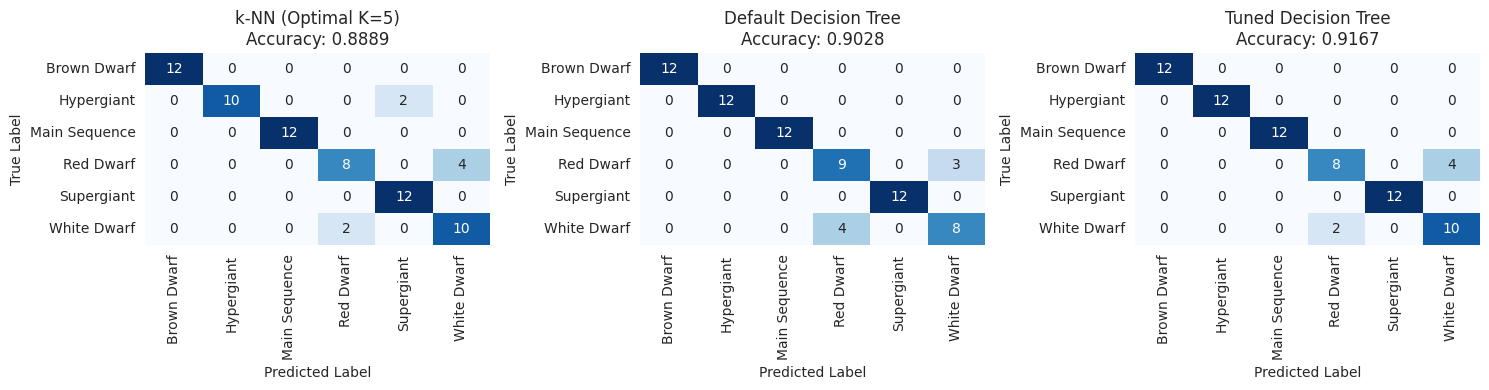

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Note: The prediction variables are used from Questions 3, 4, and 5.
predictions = {
    'k-NN (Optimal K=5)': knn_predictions,
    'Default Decision Tree': dt_default_predictions,
    'Tuned Decision Tree': dt_tuned_predictions
}

# Unique classes for the confusion matrix labels
labels = sorted(y_test.unique())
accuracy_summary = {}

print("\n\n--- MODEL PERFORMANCE EVALUATION & COMPARISON ---")

# Plot Confusion Matrices in a single figure
plt.figure(figsize=(15, 4))
for i, (name, pred) in enumerate(predictions.items()):
    # Calculate and store raw accuracy
    acc = accuracy_score(y_test, pred)
    accuracy_summary[name] = acc

    # Print Classification Report
    print(f"\n--- {name} Classification Report ---")
    print(classification_report(y_test, pred, zero_division=0))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, pred, labels=labels)
    plt.subplot(1, 3, i + 1)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', cbar=False,
        xticklabels=labels, yticklabels=labels
    )
    plt.title(f'{name}\nAccuracy: {acc:.4f}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.savefig('model_comparison_confusion_matrices.png')

# Print Final Comparison Table
print("\n\n--- FINAL ACCURACY COMPARISON ---")
print("| Model | Test Accuracy |")
print("| :--- | :--- |")
for name, acc in accuracy_summary.items():
    print(f"| {name} | {acc:.4f} |")